<a href="https://colab.research.google.com/github/ducviet00/MNIST-Handwritten-Digit-Recognition-from-scratch/blob/master/Convolutional_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
plt.rcParams['figure.figsize'] = (15.0, 10.0)


In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import concatenate
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.datasets import cifar10

Using TensorFlow backend.


In [ ]:
def plot_history(H):
    fig, ax = plt.subplots(1,2)
    ax[0].set_title('Loss')
    ax[0].plot(H.history['loss'], c='blue', label='loss')
    ax[0].plot(H.history['val_loss'], c='green', label='val_loss', linestyle='--')

    ax[1].set_title('accuracy')
    ax[1].plot(H.history['accuracy'], c='blue', label='accuracy')
    ax[1].plot(H.history['val_accuracy'], c='green', label='val_accuracy', linestyle='--')

    fig.legend('best')
    fig.show()

## Implement hàm tính convolution, input X, W, stride, padding, output Y

In [ ]:
def zero_pad(X, pad):
    """
    X - (m, n_H, n_W, n_C) represent batch m images
    pad - size pad.
    return: 
    X_pad (m, n_H + 2*pad, n_W + 2*pad, n_C)
    """
    X_pad = np.pad(X, ((0,0), (pad, pad), (pad, pad), (0,0)), mode='constant', constant_values = (0,0))
   
    return X_pad

In [ ]:
X = np.random.rand(3, 2, 3, 3)

X.shape, zero_pad(X, 1).shape

((3, 2, 3, 3), (3, 4, 5, 3))

Kích thước của ma trận $(n_{H_{prev}}, n_{W_{prev}}, n_{C_{prev}})$ 


-   $n_{H_{prev}}$ chiều cao ban đầu
-   $n_{W_{prev}}$ chiều rộng ban đầu
-   $n_{C_{prev}}$ số chanel ban đầu



$$ n_H = \lfloor \frac{n_{H_{prev}} - f + 2 \times pad}{stride} \rfloor +1 $$
$$ n_W = \lfloor \frac{n_{W_{prev}} - f + 2 \times pad}{stride} \rfloor +1 $$
$$ n_C = \text{number of filters (kernels) used in the convolution}$$

In [ ]:
def conv_simple(a_slice_prev, W, b):
    s = np.multiply(a_slice_prev, W)
    Z = np.sum(s) + np.squeeze(b)

    return Z

In [ ]:
def conv_forward(A_prev, W, b, hparameters):
    """
    A_prev -- output activations of the previous layer, 
        numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    W -- Weights, numpy array of shape (f, f, n_C_prev, n_C)
    b -- Biases, numpy array of shape (1, 1, 1, n_C)
    hparameters -- python dictionary containing "stride" and "pad"
        
    Returns:
    Z -- conv output, numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache of values needed for the conv_backward() function
    """
    
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    (f, f, n_C_prev, n_C) = W.shape
  
    stride = hparameters['stride']
    pad = hparameters['pad']
    
    n_H = int((n_H_prev - f + 2*pad)//stride + 1)
    n_W = int((n_W_prev - f + 2*pad)//stride + 1)
    Z = np.zeros((m, n_H, n_W, n_C))
    
    A_prev_pad = zero_pad(A_prev, pad)
    
    for i in range(m):               
        a_prev_pad = pad               
        for h in range(n_H):         

            vert_start = h * stride
            vert_end = vert_start + f
            
            for w in range(n_W):      

                horiz_start = w * stride
                horiz_end = horiz_start + f
                
                for c in range(n_C):   
                    a_slice_prev = A_prev_pad[i, vert_start:vert_end, horiz_start:horiz_end, :]
            
                    
                    Z[i, h, w, c] = conv_simple(a_slice_prev, W[...,c], b[...,c])
                                        

    cache = (A_prev, W, b, hparameters)
    
    return Z, cache

In [ ]:
np.random.seed(1)
A_prev = np.random.randn(10,5,7,3)
W = np.random.randn(3,3,1,2)
b = np.random.randn(1,1,1,8)
hparameters = {"pad" : 1,
               "stride": 2}

Z, cache_conv = conv_forward(A_prev, W, b, hparameters)

In [ ]:
Z.shape

(10, 3, 4, 2)

## Sobel

In [5]:
import matplotlib.image as mpimg

img = np.array(mpimg.imread('http://images6.fanpop.com/image/photos/41400000/-Kim-Jisoo-black-pink-41440749-540-403.png'))

In [12]:
img_shape = img.shape[:2]

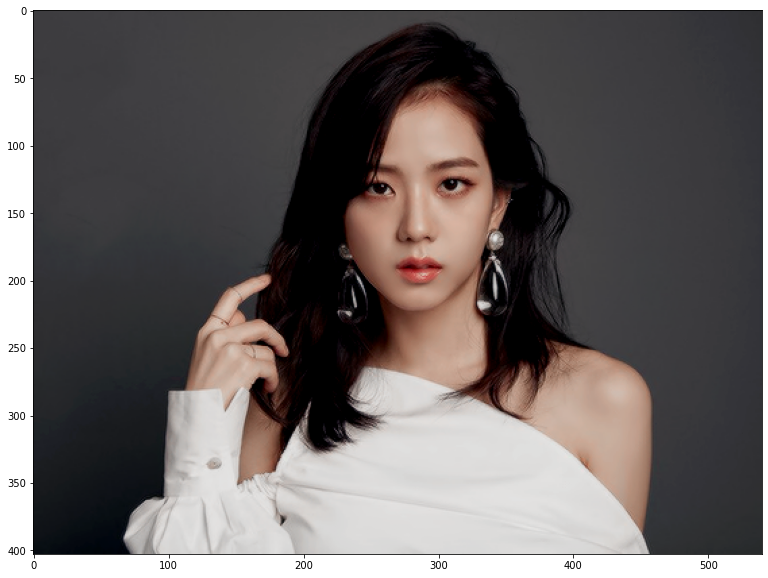

In [6]:
plt.imshow(img)

In [8]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [13]:
img_grey = np.array(rgb2gray(img)).reshape(img_shape + (1,))
#plt.imshow(img_grey, cmap=plt.get_cmap('gray'))

In [10]:
W_sobel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
W_sobel_x = np.array([[1, 0, -1], 
                      [2, 0, -2],
                      [1, 0, -1]])
W_sobel = np.array([W_sobel_x, W_sobel_y])

In [9]:
def sobel(img, W, pad, stride):
    (n_H_prev, n_W_prev, n_C_prev) = img.shape
    (n_C, f, f) = W.shape
    n_H = int((n_H_prev - f + 2*pad)//stride + 1)
    n_W = int((n_W_prev - f + 2*pad)//stride + 1)

    Z = np.zeros((n_H, n_W))

    img = np.pad(img, ((pad,pad), (pad,pad), (0,0)))

    for h in range(n_H):         

            vert_start = h * stride
            vert_end = vert_start + f
            
            for w in range(n_W):      

                horiz_start = w * stride
                horiz_end = horiz_start + f
                a_slice_prev = img[vert_start:vert_end, horiz_start:horiz_end]

                s0 = np.sum(np.multiply(a_slice_prev, W[0]))
                s1 = np.sum(np.multiply(a_slice_prev, W[1]))

                Z[h, w] = np.sqrt(s0**2 + s1**2)

    Z = Z*(255/Z.max())  

    threshold = 0 #varies for application [0 255]
    Z = np.maximum(Z, threshold)
    Z[Z==threshold] = 0
    
    return Z

In [14]:
img_sobel = sobel(img_grey, W_sobel, pad=1, stride=1)

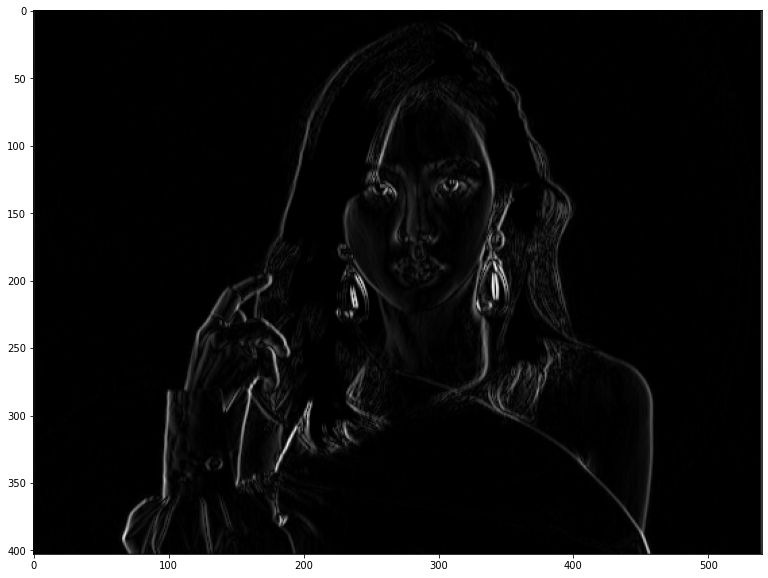

In [15]:
plt.imshow(img_sobel, cmap=plt.get_cmap('gray'))

## Implement lại code mẫu

### Load Dataset

In [ ]:
# 2. Load dữ liệu
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_val, y_val = X_train[int(0.85*len(X_train)):,:], y_train[int(0.85*len(X_train)):]
X_train, y_train = X_train[:int(0.85*len(X_train)),:], y_train[:int(0.85*len(y_train))]
print(X_train.shape)

print(X_val.shape)

170500096/170498071 [==============================] - 5s 0us/step
(42500, 32, 32, 3)
(7500, 32, 32, 3)


In [ ]:
shape = X_train[0].shape
shape

(32, 32, 3)

In [ ]:
# 3. Reshape lại dữ liệu cho đúng kích thước mà keras yêu cầu
X_train = X_train.reshape(X_train.shape[0], 32, 32, 3)
X_val = X_val.reshape(X_val.shape[0], 32, 32, 3)
X_test = X_test.reshape(X_test.shape[0], 32, 32, 3)

X_train = X_train/255.
X_test = X_test/255.
X_val = X_val/255.
print(X_train.shape)

(42500, 32, 32, 3)


In [ ]:
# 4. One hot encoding label (Y)
Y_train = np_utils.to_categorical(y_train, 10)
Y_val = np_utils.to_categorical(y_val, 10)
Y_test = np_utils.to_categorical(y_test, 10)
print('Dữ liệu y ban đầu ', y_train[0])
print('Dữ liệu y sau one-hot encoding ',Y_train[0])

Dữ liệu y ban đầu  [6]
Dữ liệu y sau one-hot encoding  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


### Train function

In [ ]:
def train(model, lr=0.001, batch_size=128, epochs=50, verbose=2):
    opt = Adam(learning_rate=lr)
    model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    
    H = model.fit(X_train, Y_train, validation_data=(X_val, Y_val),
          batch_size=batch_size, epochs=epochs, verbose=verbose)
    
    return H

In [ ]:
def simple_model():   

    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=shape))

    model.add(Conv2D(32, (3, 3), activation='relu'))

    # Thêm Max pooling layer
    model.add(MaxPooling2D(pool_size=(2,2)))

    # Flatten layer chuyển từ tensor sang vector
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))

    # Output layer với 10 node và dùng softmax function để chuyển sang xác xuất.
    model.add(Dense(10, activation='softmax'))

    model.summary()

    return model

In [ ]:
model_simple = simple_model()
H = train(model_simple)
plot_history(H)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 7200)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               921728    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 933,162
Trainable params: 933,162
Non-trainable params: 0
__________________________________________________

NameError: ignored

$\to$ Model có vẻ như bị overfit

In [ ]:
def simple_model_2():   

    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=shape))

    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(Dropout(0.3))
    # Thêm Max pooling layer
    model.add(MaxPooling2D(pool_size=(2,2)))

    # Flatten layer chuyển từ tensor sang vector
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))

    model.add(Dropout(0.3))

    # Output layer với 10 node và dùng softmax function để chuyển sang xác xuất.
    model.add(Dense(10, activation='softmax'))

    model.summary()

    return model

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 7200)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               921728    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)              

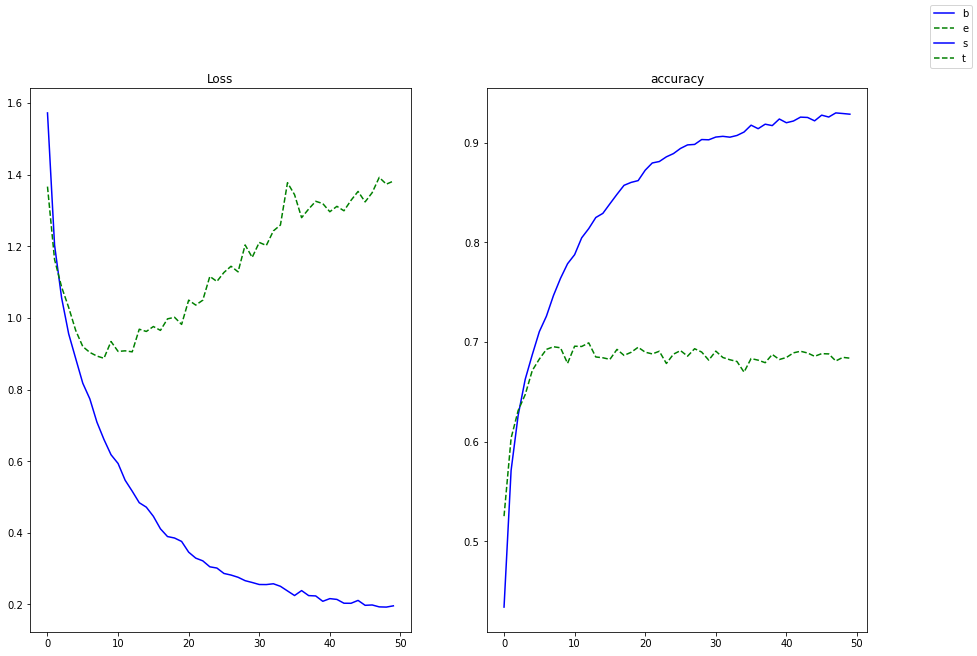

In [ ]:
model_2 = simple_model_2()
H2 = train(model_2)
plot_history(H2)

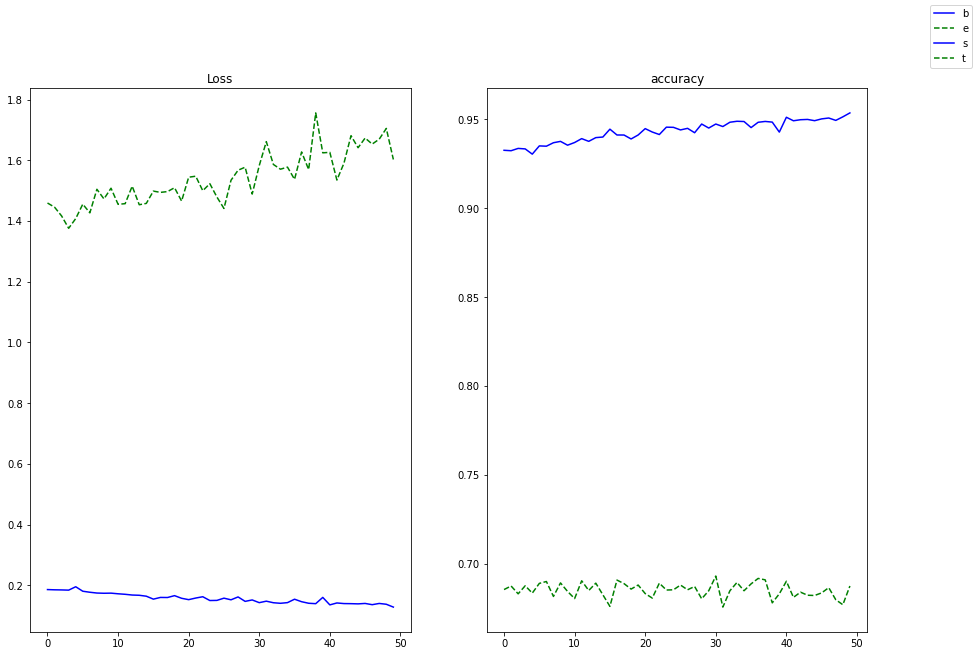

In [ ]:
H3 = train(model_2, lr=0.0001, verbose=0)
plot_history(H3)

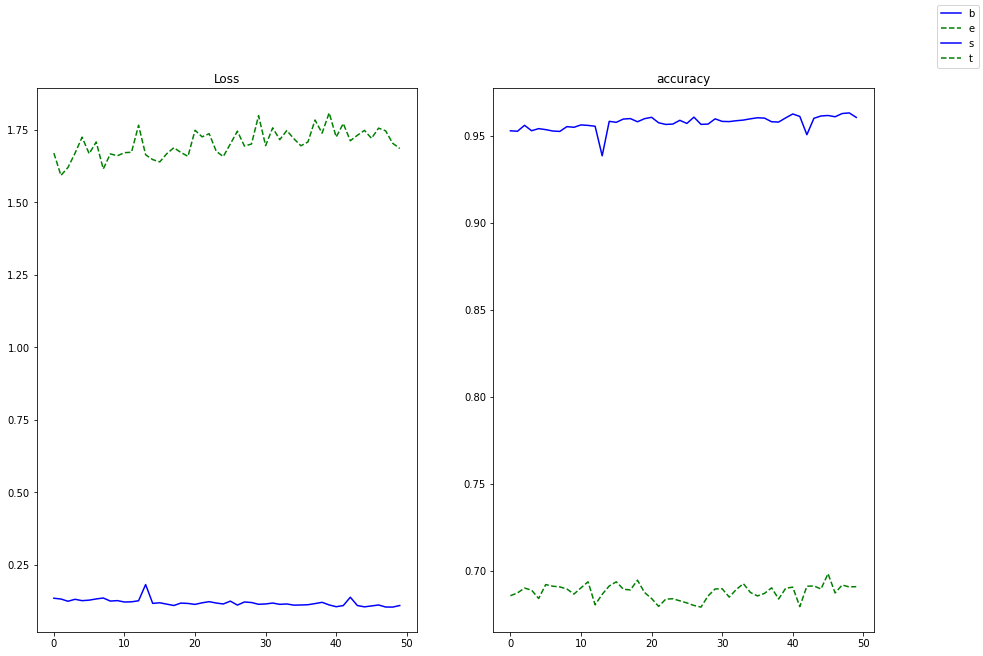

In [ ]:
H4 = train(model_2, lr=0.01, verbose=0)
plot_history(H4)

## AlexNet

![alt text](https://d2l.aivivn.com/_images/alexnet.svg)




LeNet (trái) và AlexNet (phải)

In [ ]:
def AlexNetModel():
    model = Sequential()
    
    model.add(Conv2D(filters=96,kernel_size=(3,3),strides=(1,1),input_shape=shape, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(256,(5,5),padding='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(384,(3,3),padding='same',activation='relu'))
    model.add(Conv2D(384,(3,3),padding='same',activation='relu'))
    model.add(Conv2D(256,(3,3),padding='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(4096, activation='relu'))

    model.add(Dense(10,activation='softmax'))

    model.summary()
    return model

In [ ]:
model_alexnet = AlexNetModel()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 30, 30, 96)        2688      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 15, 15, 96)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 15, 15, 256)       614656    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 7, 7, 384)         885120    
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 7, 7, 384)         1327488   
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 7, 7, 256)        

In [ ]:
H_alex = train(model_alexnet)

Epoch 1/50
333/333 - 9s - loss: 1.7159 - accuracy: 0.3547 - val_loss: 1.5560 - val_accuracy: 0.4256
Epoch 2/50
333/333 - 9s - loss: 1.2700 - accuracy: 0.5400 - val_loss: 1.1239 - val_accuracy: 0.5963
Epoch 3/50
333/333 - 9s - loss: 1.0605 - accuracy: 0.6214 - val_loss: 0.9436 - val_accuracy: 0.6676
Epoch 4/50
333/333 - 9s - loss: 0.9187 - accuracy: 0.6763 - val_loss: 0.8995 - val_accuracy: 0.6827
Epoch 5/50
333/333 - 9s - loss: 0.8001 - accuracy: 0.7184 - val_loss: 0.8805 - val_accuracy: 0.6885
Epoch 6/50
333/333 - 9s - loss: 0.7023 - accuracy: 0.7562 - val_loss: 0.9264 - val_accuracy: 0.6940
Epoch 7/50
333/333 - 9s - loss: 0.6433 - accuracy: 0.7758 - val_loss: 0.8367 - val_accuracy: 0.7165
Epoch 8/50
333/333 - 9s - loss: 0.5471 - accuracy: 0.8087 - val_loss: 0.8549 - val_accuracy: 0.7120
Epoch 9/50
333/333 - 9s - loss: 0.4902 - accuracy: 0.8299 - val_loss: 1.1611 - val_accuracy: 0.6457
Epoch 10/50
333/333 - 9s - loss: 0.4949 - accuracy: 0.8292 - val_loss: 1.0522 - val_accuracy: 0.6875

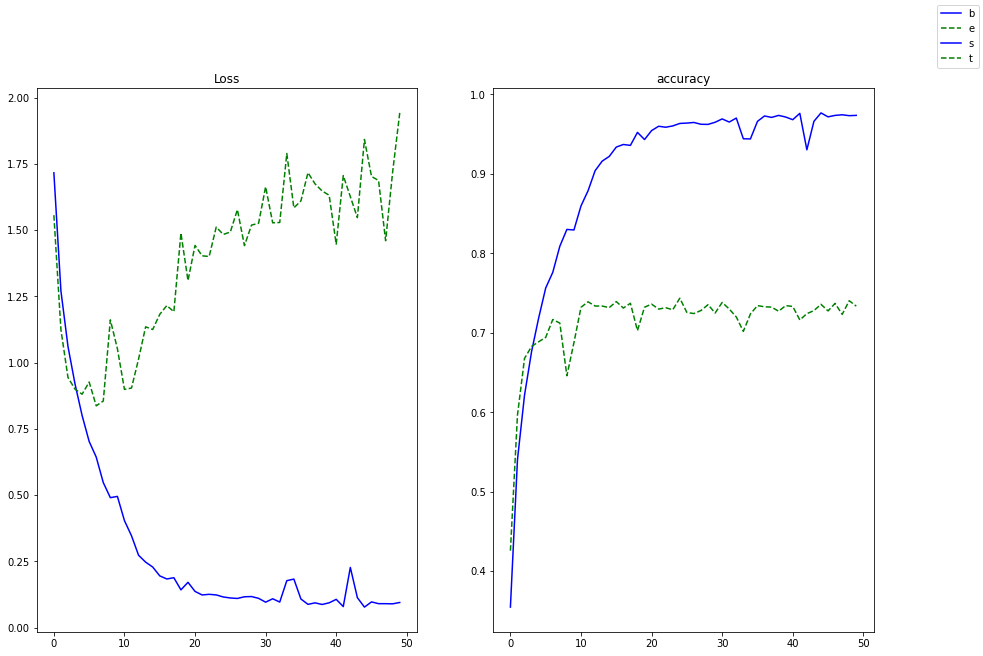

In [ ]:
plot_history(H_alex)

## VGG16

![alt text](https://d2l.aivivn.com/_images/vgg.svg)

In [ ]:
def VGG16_model():
    model = Sequential()
    
    #Block 1
    model.add(Conv2D(64, (3, 3), padding='same', input_shape=shape, activation='relu')) #1
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu')) #2
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2)))

    #Block 2
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu')) #3
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu')) #4
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2)))

    #Block 3
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu')) #5
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu')) #6
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu')) #7
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2)))

    #Block 4
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu')) #8
    model.add(BatchNormalization())
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu')) #9
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu')) #10
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2)))

    #Block 5
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu')) #11
    model.add(BatchNormalization())
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu')) #12
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu')) #13
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2)))


    model.add(Flatten())

    model.add(Dense(4096, activation='relu')) #14
    model.add(Dropout(0.3))
    
    model.add(Dense(4096, activation='relu')) #15
    
    model.add(Dense(10,activation='softmax')) #16

    model.summary()

    return model

In [ ]:
model_vgg = VGG16_model()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_13 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
dropout_9 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_14 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 16, 16, 128)      

In [ ]:
H_vgg = train(model_vgg, verbose=1)

Epoch 1/50
333/333 [==============================] - 55s 165ms/step - loss: 1.8774 - accuracy: 0.2626 - val_loss: 2.4199 - val_accuracy: 0.1708
Epoch 2/50
333/333 [==============================] - 53s 159ms/step - loss: 1.5160 - accuracy: 0.4152 - val_loss: 1.3951 - val_accuracy: 0.4663
Epoch 3/50
333/333 [==============================] - 53s 160ms/step - loss: 1.2680 - accuracy: 0.5339 - val_loss: 2.0050 - val_accuracy: 0.3984
Epoch 4/50
333/333 [==============================] - 53s 159ms/step - loss: 1.0703 - accuracy: 0.6304 - val_loss: 1.0712 - val_accuracy: 0.6265
Epoch 5/50
333/333 [==============================] - 53s 159ms/step - loss: 0.9249 - accuracy: 0.6856 - val_loss: 0.8700 - val_accuracy: 0.7017
Epoch 6/50
333/333 [==============================] - 53s 159ms/step - loss: 0.7988 - accuracy: 0.7287 - val_loss: 1.0286 - val_accuracy: 0.6540
Epoch 7/50
333/333 [==============================] - 53s 159ms/step - loss: 0.7577 - accuracy: 0.7450 - val_loss: 0.8399 - val_ac

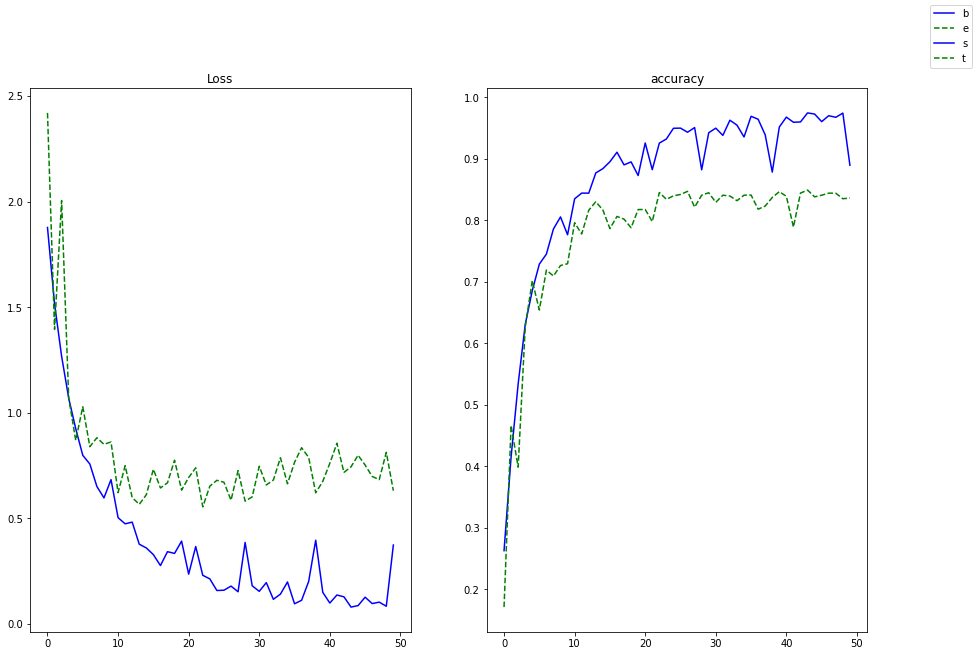

In [ ]:
plot_history(H_vgg)

In [ ]:
def VGG11_model():
    model = Sequential()
    
    #Block 1
    model.add(Conv2D(64, (3, 3), padding='same', input_shape=shape, activation='relu')) #1
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu')) #2
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2)))

    #Block 2
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu')) #3
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu')) #4
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2)))

    #Block 3
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu')) #5
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu')) #6
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu')) #7
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2)))

    #Block 4
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu')) #8
    model.add(BatchNormalization())
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu')) #9
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu')) #10
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2)))


    model.add(Flatten())

    model.add(Dense(2048, activation='relu')) #14
    model.add(Dropout(0.3))
    
    model.add(Dense(2048, activation='relu')) #15
    
    model.add(Dense(10,activation='softmax')) #16

    model.summary()

    return model

In [ ]:
model_vgg11 = VGG11_model()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_10 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
dropout_5 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_11 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 16, 16, 128)      

In [ ]:
H_vgg11 = train(model_vgg11, verbose=1)

Epoch 1/50
333/333 [==============================] - 42s 127ms/step - loss: 1.7270 - accuracy: 0.4056 - val_loss: 3.6836 - val_accuracy: 0.1013
Epoch 2/50
333/333 [==============================] - 41s 122ms/step - loss: 1.2484 - accuracy: 0.5605 - val_loss: 1.4956 - val_accuracy: 0.4973
Epoch 3/50
333/333 [==============================] - 41s 122ms/step - loss: 0.9775 - accuracy: 0.6644 - val_loss: 1.7309 - val_accuracy: 0.4885
Epoch 4/50
333/333 [==============================] - 41s 122ms/step - loss: 0.8038 - accuracy: 0.7247 - val_loss: 0.8196 - val_accuracy: 0.7291
Epoch 5/50
333/333 [==============================] - 41s 122ms/step - loss: 0.7327 - accuracy: 0.7531 - val_loss: 1.2866 - val_accuracy: 0.6291
Epoch 6/50
333/333 [==============================] - 41s 122ms/step - loss: 0.6231 - accuracy: 0.7886 - val_loss: 0.6929 - val_accuracy: 0.7801
Epoch 7/50
333/333 [==============================] - 41s 122ms/step - loss: 0.5404 - accuracy: 0.8182 - val_loss: 0.7391 - val_ac

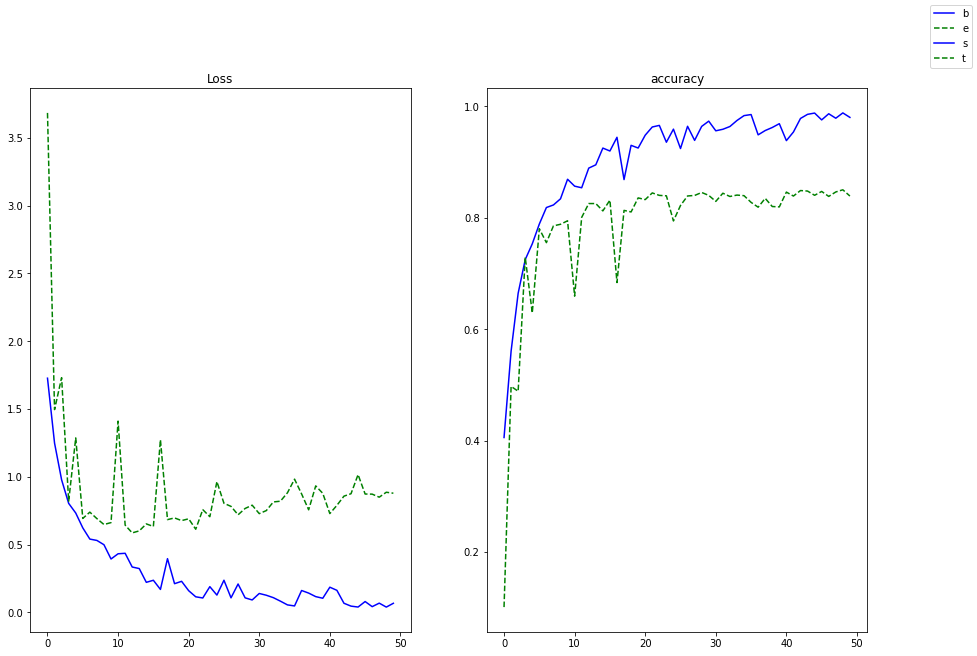

In [ ]:
plot_history(H_vgg11)

In [ ]:
def score(Y, prediction):
    prediction = np.argmax(prediction, axis=1)
    Y_label = np.argmax(Y, axis=1)

    score = 100*accuracy_score(Y_label, prediction)

    return score

In [ ]:
Y_hat_vgg11 = model_vgg11.predict(X_test)
print('Model VGG16 test accuracy: {:.2f}'.format(score(Y_test, Y_hat_vgg11)))

Model VGG16 test accuracy: 83.71


## Tại sao khi build model, càng sâu thì width, height giảm nhưng depth tăng.

- Mô hình học máy thị giác sử dụng mạng nơ-ron thông thường chỉ sử dụng các giá trị pixel để tính toán, trong khi các phương pháp khác như SVM **dùng các trích xuất đặc trưng để học**. Các bộ trích xuất đặc chưng được sử dụng như SIFT, SURF, HOG, Bags of visual words...
- Năm 2012, một nhóm các nhà nghiên cứu bao gồm **Yann LeCun, Geoff Hinton, Yoshua Bengio, Andrew Ng, Shun-ichi Amari,** và **Juergen Schmidhuber** tin rằng **đặc trưng cũng có thể được học**. Hơn nữa, họ cũng cho rằng để có được độ phức tạp hợp lý, các đặc trưng nên được phân thành thứ lớp với nhiều tầng học cùng nhau, mỗi tầng có các tham số có thể được huấn luyện. Trong trường hợp ảnh, các tầng thấp nhất có thể dùng để phát hiện biên, màu sắc và đường nét.
- Các tầng cao hơn của mạng sẽ dựa vào các biểu diễn này để thể hiện các cấu trúc lớn hơn như mắt, mũi, ngọn cỏ, v.v. Thậm chí các tầng cao hơn nữa có thể đại diện cho nguyên một vật thể như con người, máy bay, chó hoặc là đĩa ném. Sau cùng, tầng trạng thái ẩn cuối sẽ học cách biểu diễn cô đọng của toàn bộ hình ảnh để tổng hợp lại nội dung sao cho dữ liệu thuộc các lớp khác nhau có thể được dễ dàng phân biệt.


![alt text](https://d2l.aivivn.com/_images/lenet.svg)


$\to$  Tầng tích chập được sử dụng để nhận dạng các mẫu không gian trong ảnh, chẳng hạn như các đường cạnh và các bộ phận của vật thể, tuy nhiên ta không muốn kích thước của ảnh lớn, đo đó lớp gộp (*pooling*) phía sau được dùng để giảm số chiều.
